In [104]:
#1 libraries are imported here
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [105]:
def eT(T):
    y =  0.6108 * np.exp((17.27*T)/(T+237.3))
    return y

In [106]:
def ET(_Rs, _RHmax, _RHmin, _uh, _Tmax, _Tmin, _z, _J, _h, _phi_degree):
    _Tmean = (_Tmax + _Tmin) * 0.5
    _u2 = _uh * 4.87 / np.log(67.8*_h - 5.42)
    _P = 101.3 * (((293-0.0065*_z)/293)**5.26)
    _gamma = 0.000665 * _P
    _dr = 1 + 0.033 * np.cos(2 * np.pi * _J / 365)
    _dell = 0.409 * np.sin(2 * np.pi * _J / 365 - 1.39)
    _phi = (np.pi / 180) * _phi_degree
    _omega_s = np.arccos(- np.tan(_phi) * np.tan(_dell))
    _Ra = (24*60/np.pi) * _Gsc * _dr * (_omega_s * np.sin(_phi) * np.sin(_dell) + np.sin(_omega_s) * np.cos(_phi) * np.cos(_dell))
    _Rso = (0.75 + 2 * 10**-5 * _z) * _Ra
    _Rns = (1 - _albedo) * _Rs
    if(_RHmin != 0 and _RHmax != 0):
        _ea = (eT(_Tmin)*(_RHmax/100) + eT(_Tmax)*(_RHmin/100))*0.5
    else:
        _ea = eT(_Tmin)
    if(_RHmax > 0):
        _ea *=  (_RHmax/100)
    _es = 0.5 * (eT(_Tmax) + eT(_Tmin))
    _Rnl = _sigma * (((_Tmax+273.16)**4 + (_Tmin+273.16)**4)/2) * (0.34 - 0.14 * np.sqrt(_ea)) * (1.35 * (_Rs/_Rso) - 0.35)
    _Rn = _Rns - _Rnl
    _delta = 4098*(0.6108*np.exp(17.27*_Tmean/(_Tmean+237.3)))/((_Tmean+237.3)**2)
    _Cns = [[Cn_long, Cd_long], [Cn_short, Cd_short]]
    _Ets = []
    for cns in _Cns:
        _Eto_numerator = 0.408 * _delta * (_Rn - G) + _gamma * ((cns[0])/(_Tmean + 273))  * _u2 * (_es - _ea)
        _Eto_denominator = _delta + _gamma * (1 + cns[1] * _u2)
        _Eto = _Eto_numerator / _Eto_denominator
        _Ets.append(_Eto)
    _Eto = 0.0135 * kRS * (_Ra/_lambda) * np.sqrt(_Tmax-_Tmin) * (_Tmean + 17.8)
    _Ets.append(_Eto)
    return _Ets                                                                 #long_penman, short_penman, hargreeves

## Constants

## Data Processing

In [107]:
df = pd.read_excel('AWS_Data.xls')                                                     # read the csv into a variable  encoding = 'iso-8859-1'
df.drop(df.columns[[i for i in range(7, 12)]], axis = 1, inplace = True)
df.drop([0, 1, 2], inplace=True)
df_val = df.values

In [108]:
cons = pd.read_excel('AWS_Data.xls',index_col=None, sheet_name=1)
cons.drop(cons.columns[[0,1,4]], axis=1, inplace=True)
cons = cons.drop([0,1]).reset_index()
cons = cons[cons.columns[[2]]].values.flatten()

In [109]:
_z = cons[6]
_Cp =  cons[0]  
_h = cons[7]                    
_phi_degree = cons[9]
_albedo = cons[3]
Cn_long = cons[1]      
Cd_long = cons[2]          
_Gsc = cons[4]
_sigma = cons[5] 

In [110]:
G = 0
Cn_short = 900             
Cd_short = 0.34            
_lambda = 2.45             
kRS = 0.17

In [111]:
solutions = []
for i in range(df_val.shape[0]):
    par = df_val[i]
    solutions.append(ET(par[5], par[3], par[4], par[6] , par[1], par[2],_z, par[0], _h, _phi_degree))
ET_values = np.transpose(np.array(solutions))

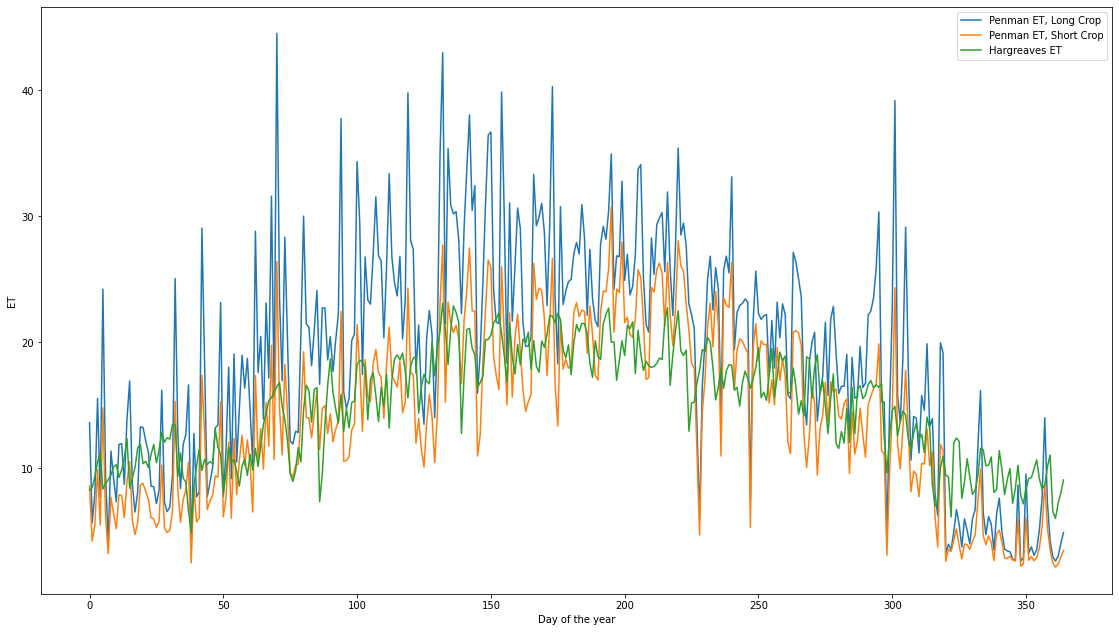

In [112]:
#7 Plot daily ET values
plt.figure(figsize=(19.2, 10.8))
plt.plot(ET_values[0], label='Penman ET, Long Crop')
plt.plot(ET_values[1], label='Penman ET, Short Crop')
plt.plot(ET_values[2], label='Hargreaves ET')
plt.legend()
plt.xlabel('Day of the year')
plt.ylabel('ET')
plt.savefig('Daily ET Values.png', dpi=200)

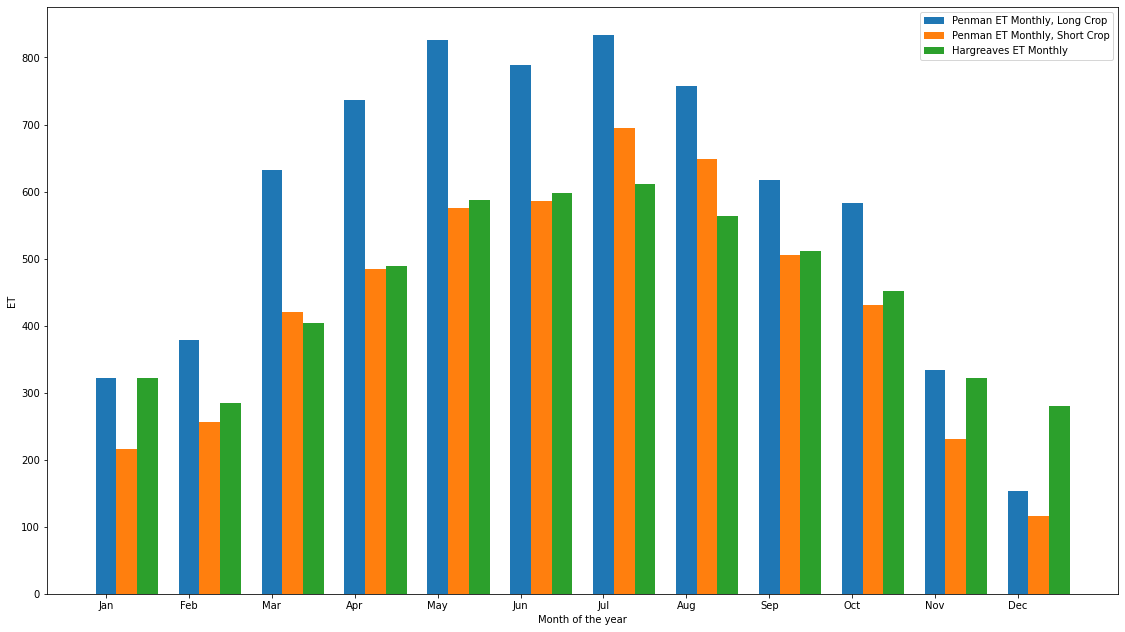

In [113]:
max_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
avg = [[0, 0, 0] for x in range(12)]
i = 0
for d in range(12):
    current_day = 0
    while( current_day < max_days[d]):
        avg[d][0] = avg[d][0] + ET_values[0][i]
        avg[d][1] = avg[d][1] + ET_values[1][i]
        avg[d][2] = avg[d][2] + ET_values[2][i]
        current_day = current_day + 1
        i = i + 1
monthly_ET_values = np.transpose(np.array(avg))
bar_width = 0.25
r1 = np.arange(len(monthly_ET_values[0]))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
fig = plt.figure(figsize=(19.2, 10.8))

plt.bar(months, monthly_ET_values[0], width=bar_width, label='Penman ET Monthly, Long Crop')
plt.bar(r2, monthly_ET_values[1], width=bar_width, label='Penman ET Monthly, Short Crop')
plt.bar(r3, monthly_ET_values[2], width=bar_width,label='Hargreaves ET Monthly')
plt.legend()
plt.xlabel('Month of the year')
plt.ylabel('ET')
plt.savefig('Monthly ET Values.png', dpi=200)

In [114]:
#9 cumulative monthly ET values from all three methods:
cum_monthly = monthly_ET_values
for d in range(1,12):
    cum_monthly[0][d] += cum_monthly[0][d-1]
    cum_monthly[1][d] += cum_monthly[1][d-1]
    cum_monthly[2][d] += cum_monthly[2][d-1]

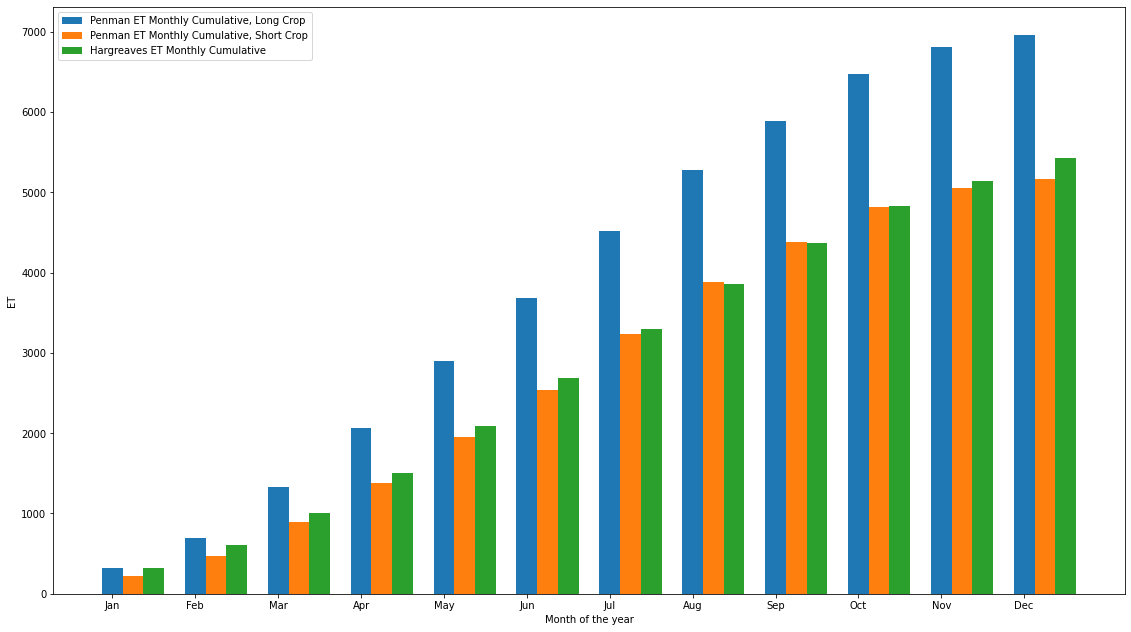

In [115]:
#10 Plotting cumulative monthly values:
r1 = np.arange(len(cum_monthly[0]))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
fig = plt.figure(figsize=(19.2, 10.8))
plt.bar(months, cum_monthly[0], width=bar_width, label='Penman ET Monthly Cumulative, Long Crop')
plt.bar(r2, cum_monthly[1], width=bar_width, label='Penman ET Monthly Cumulative, Short Crop')
plt.bar(r3, cum_monthly[2], width=bar_width,label='Hargreaves ET Monthly Cumulative')
plt.legend()
plt.xlabel('Month of the year')
plt.ylabel('ET')
plt.savefig('Cumulative Monthly ET Values.png', dpi=200)

In [116]:
#11 Cumulative Daily ET values:
cum_ET =  ET_values
for i in range(1, 365):
    cum_ET[0][i] += cum_ET[0][i-1]
    cum_ET[1][i] += cum_ET[1][i-1]
    cum_ET[2][i] += cum_ET[2][i-1]

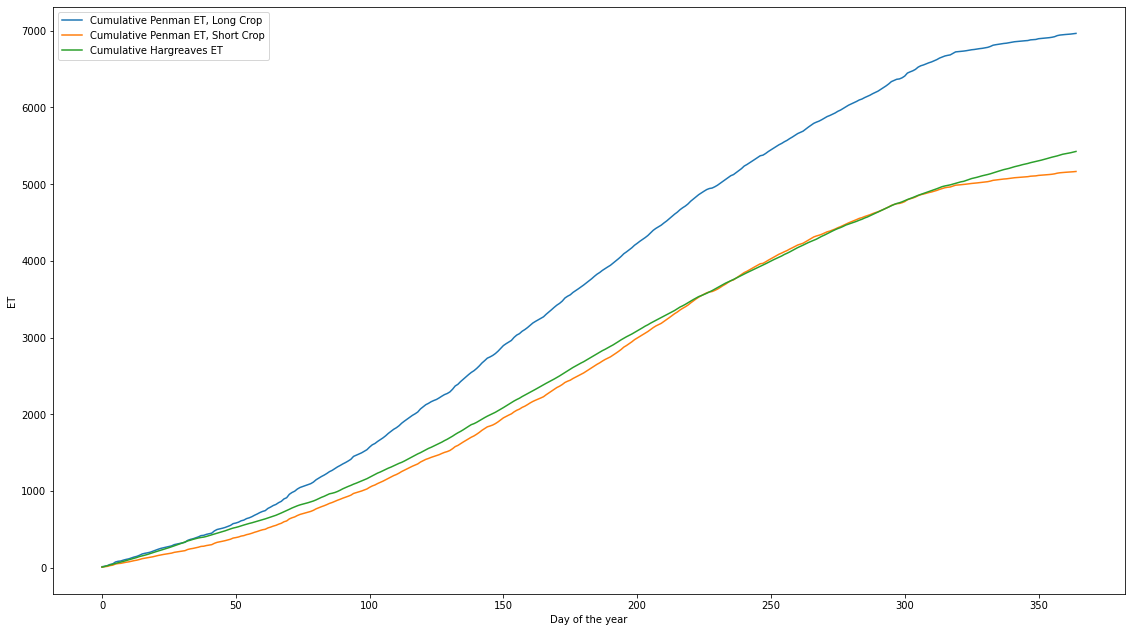

In [117]:
#13 Plotting cumulative daily values:
plt.figure(figsize=(19.2, 10.8))
plt.plot(cum_ET[0], label='Cumulative Penman ET, Long Crop')
plt.plot(cum_ET[1], label='Cumulative Penman ET, Short Crop')
plt.plot(cum_ET[2], label='Cumulative Hargreaves ET')
plt.legend()
plt.xlabel('Day of the year')
plt.ylabel('ET')
plt.savefig('Cumulative Daily ET Values.png', dpi=200)

In [118]:
#14 Generate daily ET Cumulative values
f = open('Cumulative Daily.txt', 'a')
f.write('Long_Penman_Daily_Cumulative, Short_Penman_Daily_Cumulative, Hargreaves_Cumulative\n')
np.set_printoptions(threshold=np.inf)
f.write(np.array_str(np.transpose(ET_values)))
f.close()

In [119]:
#15 Generate monthly ET Cumulative values
f = open('Cumulative Monthly.txt', 'a')
f.write('Long_Penman_Monthly_Cumulative, Short_Penman_Monthly_Cumulative, Hargreaves_Cumulative\n')
f.write(np.array_str(np.transpose(monthly_ET_values)))
f.close()